In [1]:
!curl -L 'https://nanum.etri.re.kr/share/download?fileKind=share&id=1419' \
  -H 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.7' \
  -H 'Accept-Language: ko-KR,ko;q=0.9,en-US;q=0.8,en;q=0.7' \
  -H 'Connection: keep-alive' \
  -b 'XSRF-TOKEN=32fbf965-67d3-4d0d-b80f-6c08e2c23728; notice=%7B%22secure%22%3Atrue%2C%22SameSite%22%3A%22lax%22%2C%22fir%22%3A%7B%22isShow%22%3Afalse%7D%2C%22sec%22%3A%7B%22isShow%22%3Afalse%7D%7D; JSESSIONID=8049D2DC31C820354F412E667A56CB6C' \
  -H 'Referer: https://nanum.etri.re.kr/share/kimjy/ObjectStateDetectionAIchallenge2024?lang=ko_KR' \
  -H 'Sec-Fetch-Dest: document' \
  -H 'Sec-Fetch-Mode: navigate' \
  -H 'Sec-Fetch-Site: same-origin' \
  -H 'Sec-Fetch-User: ?1' \
  -H 'Upgrade-Insecure-Requests: 1' \
  -H 'User-Agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/143.0.0.0 Safari/537.36' \
  --output etri_dataset.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31.8G    0 31.8G    0     0  9781k      0 --:--:--  0:56:51 --:--:-- 10.3M


In [1]:
!unzip -q "/content/drive/MyDrive/shared_drive/차량상태인식.zip" -d /content/dataset

In [ ]:
import os
from collections import Counter

def analyze_folder(path):
    print(f"📂 분석 경로: {path}")
    print("-" * 50)

    for root, dirs, files in os.walk(path):
        # 현재 폴더의 파일 개수 계산
        if not files:
            continue

        rel_path = os.path.relpath(root, path)
        ext_counter = Counter([os.path.splitext(f)[1].lower() for f in files])

        # 파일 확장자별 통계 생성
        ext_str = ", ".join([f"{ext}: {count}개" for ext, count in ext_counter.items()])

        # 전체 용량 계산
        total_size = sum(os.path.getsize(os.path.join(root, f)) for f in files) / (1024 * 1024) # MB

        print(f"📁 {rel_path}")
        print(f"   📄 총 파일: {len(files)}개 | 💾 용량: {total_size:.2f} MB")
        print(f"   🔍 확장자: {ext_str}")
        print("-" * 50)

# 압축 푼 폴더 경로 입력
analyze_folder('./car_dataset/train/')

📂 분석 경로: ./car_dataset/train
--------------------------------------------------
📁 Banseok01_Snow/img
   📄 총 파일: 3717개 | 💾 용량: 2660.81 MB
   🔍 확장자: .png: 3717개
--------------------------------------------------
📁 Banseok01_Snow/instance
   📄 총 파일: 3717개 | 💾 용량: 10.19 MB
   🔍 확장자: .png: 3717개
--------------------------------------------------
📁 Banseok01_Snow/new_txt
   📄 총 파일: 3717개 | 💾 용량: 0.62 MB
   🔍 확장자: .txt: 3717개
--------------------------------------------------
📁 InsideETRI_Day/img
   📄 총 파일: 258개 | 💾 용량: 207.35 MB
   🔍 확장자: .png: 258개
--------------------------------------------------
📁 InsideETRI_Day/instance
   📄 총 파일: 258개 | 💾 용량: 0.60 MB
   🔍 확장자: .png: 258개
--------------------------------------------------
📁 InsideETRI_Day/new_txt
   📄 총 파일: 258개 | 💾 용량: 0.02 MB
   🔍 확장자: .txt: 258개
--------------------------------------------------
📁 TailLight65/img
   📄 총 파일: 17개 | 💾 용량: 15.89 MB
   🔍 확장자: .png: 17개
--------------------------------------------------
📁 TailLight65/insta

In [ ]:
from pathlib import Path
train_dataset = Path("./car_dataset/train")

[Data 확인] bounding box 시각화

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def visualize_perfect_labels(image_path, label_path):
    # 1. 이미지 로드
    img = cv2.imread(image_path)
    if img is None:
        print("이미지를 찾을 수 없습니다.")
        return
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # 2. 레이블 파일 읽기
    with open(label_path, 'r') as f:
        lines = f.readlines()

    for line in lines:
        data = list(map(float, line.split()))
        if len(data) < 10: continue # 데이터 부족 시 패스

        # --- 인덱스 정의에 따른 데이터 추출 ---
        # 0, 1, 2, 3: x1, y1, x2, y2 (절대 좌표)
        x1, y1, x2, y2 = map(int, data[0:4])

        # 4: Agent, 5: Location
        agent = int(data[4])
        location = int(data[5])

        # 6-9: Action (One-hot encoding)
        # 예: [1, 0, 0, 0] -> 0번 액션 / [0, 1, 0, 0] -> 1번 액션
        actions = data[6:10]
        action_idx = np.argmax(actions) if sum(actions) > 0 else -1

        # 3. 바운딩 박스 그리기 (절대 좌표이므로 바로 사용)
        # Location 4(선행차로)는 빨간색, 나머지는 하늘색으로 구분
        color = (255, 0, 0) if location == 4 else (0, 255, 255)
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

        # 4. 정보 텍스트 생성
        # Agent 종류와 Action 번호를 표시
        label_text = f"A:{agent} L:{location} Act:{action_idx}"

        # 텍스트 가독성을 위해 배경 살짝 넣기
        cv2.putText(img, label_text, (x1, y1 - 7),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # 5. 결과 출력
    plt.figure(figsize=(16, 9))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Visualized: {image_path.split('/')[-1]}")
    plt.show()

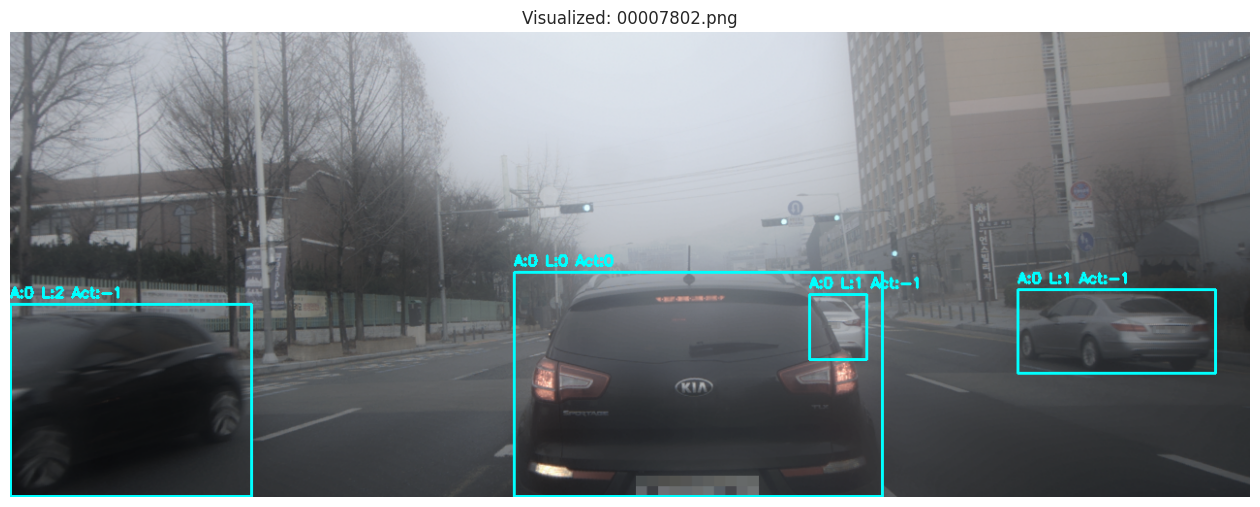

In [ ]:
visualize_perfect_labels('/content/car_dataset/train/Clockwise_Fog/img/00007802.png', '/content/car_dataset/train/Clockwise_Fog/new_txt/00007802.txt')

### [EDA] 분포 분석

In [ ]:
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

def analyze_data_distribution(root_path):
    # 1. 모든 txt 파일 경로 수집 (train/*/new_txt/*.txt 패턴)
    txt_files = glob.glob(os.path.join(root_path, "*/new_txt/*.txt"))
    print(f"총 {len(txt_files)}개의 레이블 파일을 찾았습니다.")

    # 카운터 초기화
    agent_list = []
    location_list = []
    action_counts = {"Brake": 0, "Left": 0, "Right": 0, "Emergency": 0}
    total_objects = 0

    # 2. 파일 전수 조사
    for file_path in txt_files:
        with open(file_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                data = list(map(float, line.split()))
                if len(data) < 10: continue

                total_objects += 1

                # 인덱스 기준 추출
                agent = int(data[4])      # 4번: Agent (0:차, 1:버스)
                location = int(data[5])   # 5번: Location (0~4)

                # 6-9번: Action (Brake, Left, Right, Emergency)
                action_counts["Brake"] += int(data[6])
                action_counts["Left"] += int(data[7])
                action_counts["Right"] += int(data[8])
                action_counts["Emergency"] += int(data[9])

                agent_list.append(agent)
                location_list.append(location)

    # 3. 데이터 요약
    agent_dist = Counter(agent_list)
    loc_dist = Counter(location_list)

    # 매핑 이름 정의 (그림 기준)
    agent_names = {0: "Car", 1: "Bus"}
    loc_names = {0: "Ego Lane", 1: "Adj Lane", 2: "Opposite", 3: "Intersection", 4: "Parking"}

    # 4. 시각화 (3개 서브플롯)
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    plt.subplots_adjust(wspace=0.3)

    # (1) Agent 분포
    sns.barplot(x=[agent_names.get(k, k) for k in agent_dist.keys()],
                y=list(agent_dist.values()), ax=axes[0], palette="viridis")
    axes[0].set_title(f"Agent Distribution (Total: {total_objects})")

    # (2) Location 분포
    sns.barplot(x=[loc_names.get(k, k) for k in loc_dist.keys()],
                y=list(loc_dist.values()), ax=axes[1], palette="magma")
    axes[1].set_title("Location Distribution")
    axes[1].tick_params(axis='x', rotation=45)

    # (3) Action 분포 (Action은 중복 발생 가능하므로 별도 합산 결과 사용)
    sns.barplot(x=list(action_counts.keys()),
                y=list(action_counts.values()), ax=axes[2], palette="rocket")
    axes[2].set_title("Action (State) Counts")

    plt.show()

    # 정량 수치 출력
    print("\n--- 분석 결과 요약 ---")
    print(f"전체 객체 수: {total_objects}")
    print(f"Agent 비율: {dict(agent_dist)}")
    print(f"Location 비율: {dict(loc_dist)}")
    print(f"Action 합계: {action_counts}")

# 코랩 환경에서 실행 시 root_path를 압축 푼 train 폴더 경로로 지정하세요.
# analyze_data_distribution('./dataset/train')

총 33187개의 레이블 파일을 찾았습니다.


/tmp/ipython-input-1496274534.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[agent_names.get(k, k) for k in agent_dist.keys()],
/tmp/ipython-input-1496274534.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[loc_names.get(k, k) for k in loc_dist.keys()],
/tmp/ipython-input-1496274534.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(action_counts.keys()),


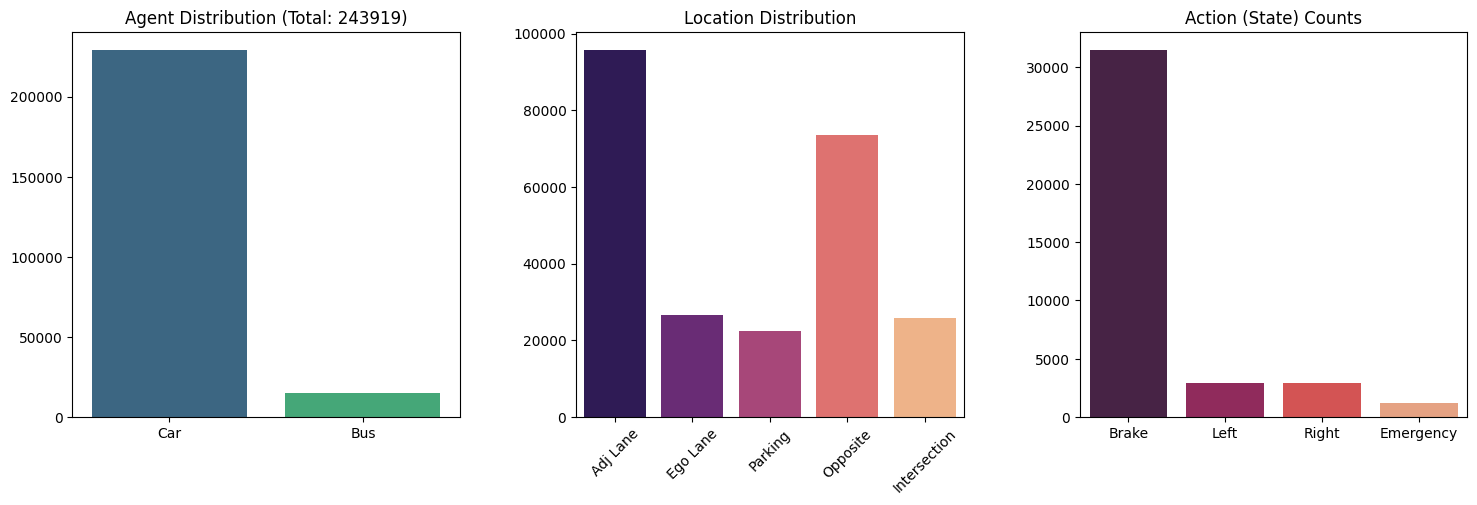


--- 분석 결과 요약 ---
전체 객체 수: 243919
Agent 비율: {0: 228864, 1: 15055}
Location 비율: {1: 95619, 0: 26523, 4: 22377, 2: 73605, 3: 25795}
Action 합계: {'Brake': 31433, 'Left': 2964, 'Right': 2935, 'Emergency': 1178}


In [ ]:
analyze_data_distribution('./car_dataset/train')

### [EDA] 객체 크기(영역) 분포 분석 (Box Area Analysis)

In [ ]:
import numpy as np

def analyze_box_size(root_path):
    txt_files = glob.glob(os.path.join(root_path, "*/new_txt/*.txt"))
    areas = []

    for file_path in txt_files:
        with open(file_path, 'r') as f:
            for line in f.readlines():
                data = list(map(float, line.split()))
                # 절대 좌표 x1, y1, x2, y2 기준
                w = data[2] - data[0]
                h = data[3] - data[1]
                areas.append(w * h)

    plt.figure(figsize=(10, 5))
    sns.histplot(areas, bins=50, kde=True, color='blue')
    plt.title("Bounding Box Area Distribution")
    plt.xlabel("Area (pixels)")
    plt.ylabel("Count")
    plt.show()

    print(f"평균 크기: {np.mean(areas):.2f}, 중앙값: {np.median(areas):.2f}")

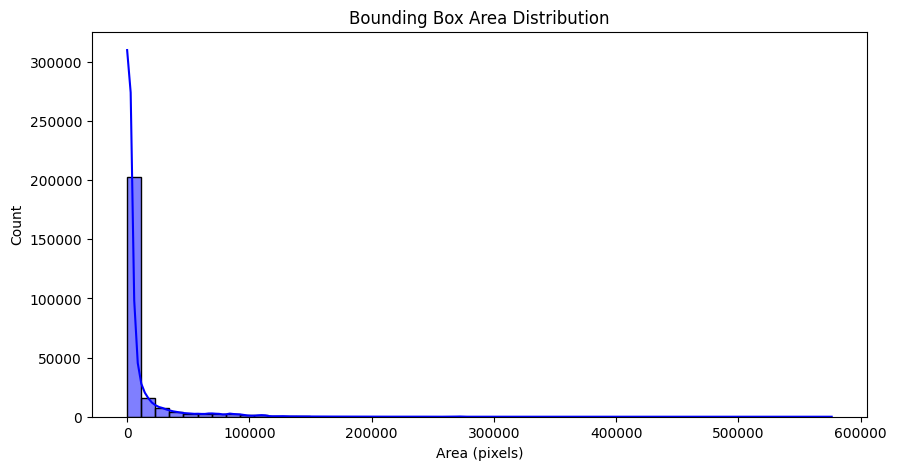

평균 크기: 9543.13, 중앙값: 1720.00


In [ ]:
analyze_box_size('./car_dataset/train')

### [EDA] 위치별 상태 상관관계 (Location-Action Correlation)


In [ ]:
import pandas as pd

def analyze_location_action_corr(root_path):
    txt_files = glob.glob(os.path.join(root_path, "*/new_txt/*.txt"))
    corr_data = []

    for file_path in txt_files:
        with open(file_path, 'r') as f:
            for line in f.readlines():
                data = list(map(float, line.split()))
                # Location(5), Brake(6)
                corr_data.append({'Location': int(data[5]), 'Brake': int(data[6])})

    df = pd.DataFrame(corr_data)
    # Location별 Brake 비율 계산
    brake_rate = df.groupby('Location')['Brake'].mean()

    loc_names = {0: "Ego", 1: "Adj", 2: "Opp", 3: "Inter", 4: "Park"}
    brake_rate.index = [loc_names.get(i, i) for i in brake_rate.index]

    brake_rate.plot(kind='bar', color='salmon', figsize=(8, 5))
    plt.title("Brake ON Rate by Location")
    plt.ylabel("Probability")
    plt.show()

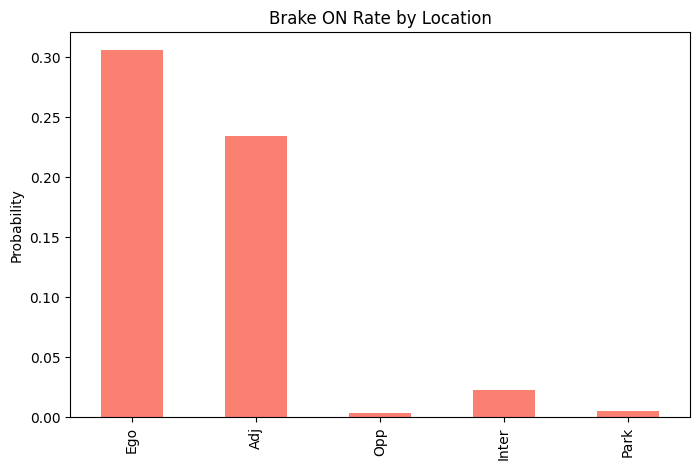

In [ ]:
analyze_location_action_corr('./car_dataset/train')

In [ ]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_action_ratio_by_location(root_path):
    # 1. 모든 txt 파일 경로 수집
    txt_files = glob.glob(os.path.join(root_path, "*/new_txt/*.txt"))

    all_data = []

    # 2. 데이터 추출
    for file_path in txt_files:
        with open(file_path, 'r') as f:
            for line in f.readlines():
                data = list(map(float, line.split()))
                if len(data) < 10: continue

                # 데이터 구성: ... Agent(4), Loc(5), Brake(6), Left(7), Right(8), Emergency(9)
                all_data.append({
                    'Location': int(data[5]),
                    'Brake': int(data[6]),
                    'Left': int(data[7]),
                    'Right': int(data[8]),
                    'Emergency': int(data[9])
                })

    # 3. 데이터프레임 변환
    df = pd.DataFrame(all_data)

    # 위치 ID를 이름으로 매핑
    loc_names = {0: "Ego Lane", 1: "Adj Lane", 2: "Opposite", 3: "Intersection", 4: "Parking"}
    df['Location_Name'] = df['Location'].map(loc_names)

    # 4. 위치별 각 Action의 평균(비율) 계산
    # mean()을 취하면 0과 1 사이의 발생 확률이 나옵니다.
    summary_df = df.groupby('Location_Name')[['Brake', 'Left', 'Right', 'Emergency']].mean().reset_index()

    # 시각화를 위해 'Tidy Data' 형식으로 변환 (Melt)
    melted_df = summary_df.melt(id_vars='Location_Name', var_name='Action_Type', value_name='Ratio')

    # 5. 시각화
    plt.figure(figsize=(14, 7))
    sns.set_style("whitegrid")

    ax = sns.barplot(data=melted_df, x='Location_Name', y='Ratio', hue='Action_Type', palette='muted')

    # 그래프 꾸미기
    plt.title("Action Ratio by Location", fontsize=16, pad=20)
    plt.xlabel("Location (Vehicle Position)", fontsize=12)
    plt.ylabel("Occurence Ratio (0.0 ~ 1.0)", fontsize=12)
    plt.legend(title="Action Type", bbox_to_anchor=(1.05, 1), loc='upper left')

    # 막대 위에 수치 표시
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'center',
                    xytext = (0, 9),
                    textcoords = 'offset points',
                    fontsize=9)

    plt.tight_layout()
    plt.show()

    # 정량 데이터 요약표 출력
    print("\n--- [위치별 Action 발생 비율 요약표] ---")
    print(summary_df.to_string(index=False))



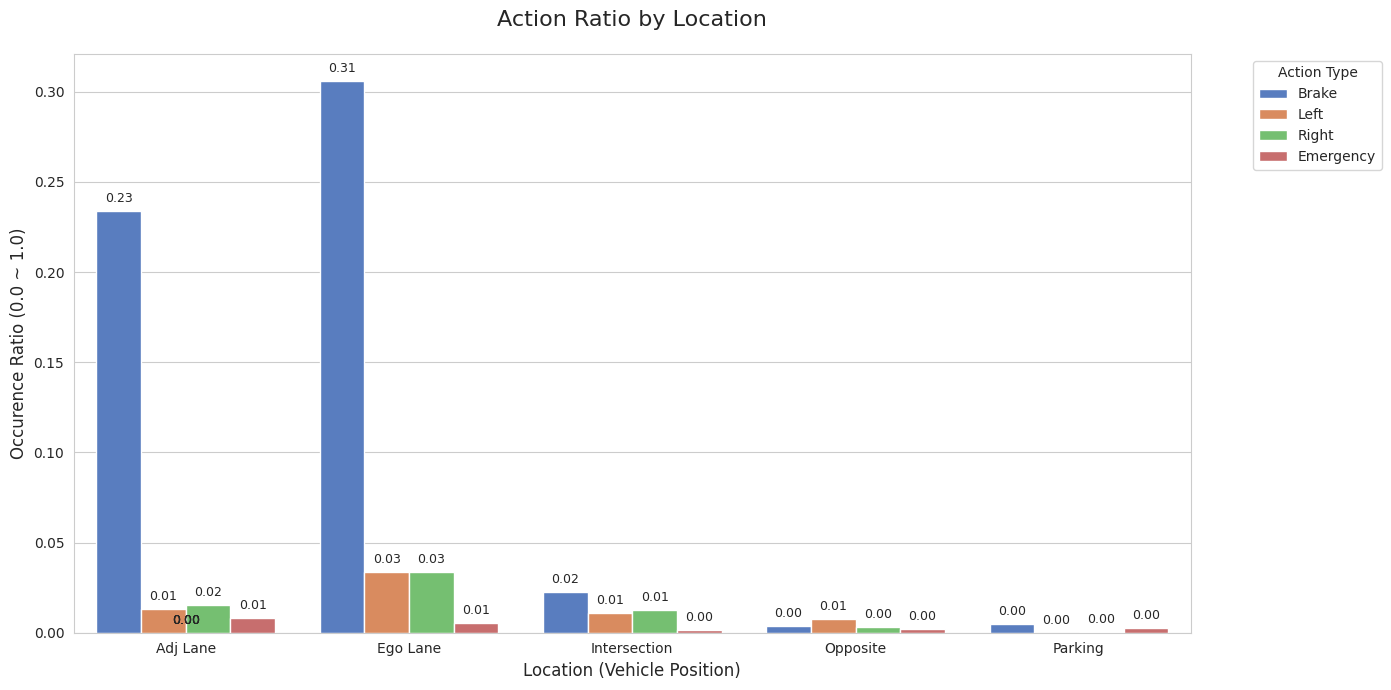


--- [위치별 Action 발생 비율 요약표] ---
Location_Name    Brake     Left    Right  Emergency
     Adj Lane 0.234043 0.012937 0.015457   0.008116
     Ego Lane 0.305772 0.033782 0.033480   0.005354
 Intersection 0.022718 0.010855 0.012677   0.001589
     Opposite 0.003451 0.007459 0.003166   0.002174
      Parking 0.004648 0.000089 0.000402   0.002637


In [ ]:
analyze_action_ratio_by_location('./car_dataset/train')

### [EDA] LLM 활용 위험도 및 폴더별 장면 분석

In [ ]:
!pip install openai

In [ ]:
# .env 파일 생성하기
with open(".env", "w") as f:
    f.write("OPENAI_API_KEY=")
    f.write("OTHER_VAR=value\n")

# 파일이 잘 만들어졌는지 확인
!ls -a

.	     dataset_summary_report.json       ETRI_Dataset.zip
..	     dataset_summary_report_test.json  .ipynb_checkpoints
car_dataset  .env			       sample_data
.config      etri_dataset.zip		       untitled


In [ ]:
!pip install python-dotenv -q
import os
from dotenv import load_dotenv

In [ ]:
import os
import glob
import base64
import json
import pandas as pd # 결과 확인용
from openai import OpenAI

load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")
# 1. 클라이언트 초기화
client = OpenAI(api_key=api_key)

def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

# 2. 프롬프트 템플릿 (folder_name 추가)
SYSTEM_PROMPT = "당신은 자율주행 시나리오 전문가입니다. 반드시 JSON 형식으로만 답변하세요."

USER_PROMPT_TEMPLATE = """
이 이미지는 자율주행 차량의 전방 카메라 뷰입니다. 다음 항목을 분석해서 JSON으로 응답해 주세요:

1. folder_name: "{folder_name}" (반드시 이 값을 포함하세요)
2. weather_time: (Sunny, Rainy, Cloudy, Night 중 택 1)
3. road_condition: (정체 중, 원활, 교차로 대기 중, 주차장 등)
4. hazards: (무단횡단, 끼어들기, 좁은 골목 등 주요 위험 요소)
5. risk_score: (1-10 사이 정수)
6. summary: (상황 요약 1문장)

응답 형식 예시:
{{
  "folder_name": "{folder_name}",
  "weather_time": "Sunny",
  "road_condition": "원활",
  "hazards": "없음",
  "risk_score": 2,
  "summary": "맑은 날씨에 차량 흐름이 원활한 시내 도로를 주행 중입니다."
}}
"""

def analyze_dataset_with_folder_names(root_path):
    # 폴더 구조에 따라 경로 수정 (예: train/*/new_png/000000.png)
    representative_images = glob.glob(os.path.join(root_path, "*/img/000000.png"))

    final_results = [] # 리스트 형태로 저장 (Pandas 변환 용이)

    for img_path in representative_images:
        # 폴더명 추출 (경로 구조에 따라 인덱스 확인 필요)
        folder_name = img_path.split('/')[-3]
        print(f"🚀 분석 시작: {folder_name}")

        try:
            base64_image = encode_image(img_path)

            # 3. OpenAI API 호출
            response = client.chat.completions.create(
                model="gpt-4o-mini", # 가성비 좋은 모델 추천
                messages=[
                    {"role": "system", "content": SYSTEM_PROMPT},
                    {
                        "role": "user",
                        "content": [
                            {"type": "text", "text": USER_PROMPT_TEMPLATE.format(folder_name=folder_name)},
                            {
                                "type": "image_url",
                                "image_url": {"url": f"data:image/png;base64,{base64_image}",
                                              "detail": "low"},
                            },
                        ],
                    }
                ],
                response_format={"type": "json_object"}
            )

            # 결과 로드 및 리스트에 추가
            result_json = json.loads(response.choices[0].message.content)
            final_results.append(result_json)
            print(f"✅ 완료: {folder_name} (Score: {result_json['risk_score']})")

        except Exception as e:
            print(f"❌ 에러 발생 ({folder_name}): {e}")

    # 4. JSON 파일 저장
    output_filename = "dataset_summary_report_test.json"
    with open(output_filename, "w", encoding="utf-8") as f:
        json.dump(final_results, f, indent=4, ensure_ascii=False)

    print(f"\n✨ 모든 분석 완료! 결과 저장: {output_filename}")
    return final_results

In [ ]:
analyze_dataset_with_folder_names('./car_dataset/test')

🚀 분석 시작: Yongsan_Cons
✅ 완료: Yongsan_Cons (Score: 3)

✨ 모든 분석 완료! 결과 저장: dataset_summary_report_test.json


[{'folder_name': 'Yongsan_Cons',
  'weather_time': 'Sunny',
  'road_condition': '원활',
  'hazards': '없음',
  'risk_score': 3,
  'summary': '맑은 날씨에 차량이 원활하게 흐르는 도로에서 주행 중입니다.'}]

### [YOLO Format] YOLO 포맷 변환 및 data.yaml

In [2]:
import os
import glob
import cv2
import shutil
import pandas as pd

def prepare_yolo_dataset_by_csv(root_path, csv_path, output_path):
    # 1. CSV 파일 읽기 및 매핑 사전 생성
    # utf-8-sig는 파일 시작의 BOM(\ufeff)을 제거하기 위함입니다.
    df = pd.read_csv(csv_path, encoding='utf-8-sig')

    # 필요한 컬럼만 추출하고 유효한 split 값만 필터링
    df = df[['env', 'split']].dropna()
    df = df[df['split'].isin(['train', 'val', 'test'])]

    # env명을 key로, split(train/val/test)을 value로 하는 사전 생성
    split_map = dict(zip(df['env'], df['split']))
    print(f"✅ CSV 로드 완료: {len(split_map)}개의 환경(env) 설정 읽음.")

    # 2. 모든 png 파일 찾기
    # 데이터 구조에 맞춰 **/img/*.png 패턴으로 검색
    image_paths = glob.glob(os.path.join(root_path, "**/img/*.png"), recursive=True)
    print(f"총 {len(image_paths)}개의 이미지를 찾았습니다.")

    if len(image_paths) == 0:
        print("❌ 이미지를 찾지 못했습니다. 경로를 확인해주세요.")
        return

    # 3. 폴더 구조 생성 (train, val, test)
    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(output_path, split, 'images'), exist_ok=True)
        os.makedirs(os.path.join(output_path, split, 'labels'), exist_ok=True)

    # 4. 데이터 처리 및 복사
    processed_count = 0
    missing_env_count = 0

    for img_path in image_paths:
        path_parts = img_path.split(os.sep)

        # 구조가 'folder/img/file.png' 일 때:
        # path_parts[-3] = 폴더명(env)
        folder_name = path_parts[-3]
        file_name = path_parts[-1]

        # CSV에 정의된 split 찾기
        target_split = split_map.get(folder_name)

        if not target_split:
            # CSV에 없는 폴더는 건너뜁니다.
            missing_env_count += 1
            continue

        # 새로운 파일명 생성: ArtHall_000000.png
        new_base_name = f"{folder_name}_{file_name}"
        new_label_name = new_base_name.replace('.png', '.txt')

        # 원본 라벨 경로 찾기 (img -> new_txt)
        org_label_path = img_path.replace('img', 'new_txt').replace('.png', '.txt')

        if not os.path.exists(org_label_path):
            continue

        # 이미지 로드 및 크기 확인
        img = cv2.imread(img_path)
        if img is None: continue
        h, w, _ = img.shape

        yolo_labels = []
        with open(org_label_path, 'r') as f:
            for line in f.readlines():
                data = list(map(float, line.split()))
                if len(data) < 5: continue

                # 0-3: 절대좌표(x1, y1, x2, y2), 4: Agent(Class)
                x1, y1, x2, y2 = data[0:4]
                class_id = int(data[4])

                # YOLO 정규화 변환
                xc = ((x1 + x2) / 2) / w
                yc = ((y1 + y2) / 2) / h
                nw = (x2 - x1) / w
                nh = (y2 - y1) / h

                yolo_labels.append(f"{class_id} {xc:.6f} {yc:.6f} {nw:.6f} {nh:.6f}")

        if yolo_labels:
            # 1. 이미지 복사 (지정된 split 폴더로)
            target_img_path = os.path.join(output_path, target_split, 'images', new_base_name)
            shutil.copy(img_path, target_img_path)

            # 2. YOLO 라벨 저장 (지정된 split 폴더로)
            target_label_path = os.path.join(output_path, target_split, 'labels', new_label_name)
            with open(target_label_path, 'w') as f:
                f.write("\n".join(yolo_labels))

            processed_count += 1

    print("-" * 30)
    print(f"✨ 처리 완료!")
    print(f"- 성공적으로 변환된 이미지: {processed_count}장")
    print(f"- CSV에 정의되지 않아 제외된 폴더: {missing_env_count}개")
    print(f"- 결과 저장소: {os.path.abspath(output_path)}")

# --- 실행 방법 ---
# root_path: 원본 데이터가 있는 곳 (예: dataset/train)
# csv_path: 제공해주신 csv 파일 경로
# output_path: YOLO 포맷으로 저장될 경로
# prepare_yolo_dataset_by_csv('./dataset/train', './split_assignment.csv', './yolo_final_data')

In [4]:
prepare_yolo_dataset_by_csv('./dataset/train', './split_assignment.csv', './yolo_final_data')

✅ CSV 로드 완료: 165개의 환경(env) 설정 읽음.
총 33187개의 이미지를 찾았습니다.
------------------------------
✨ 처리 완료!
- 성공적으로 변환된 이미지: 33187장
- CSV에 정의되지 않아 제외된 폴더: 0개
- 결과 저장소: /content/yolo_final_data


In [5]:
import yaml

def create_data_yaml(yolo_data_path):
    # 절대 경로로 설정
    abs_path = os.path.abspath(yolo_data_path)

    data = {
        'path': abs_path,
        'train': 'train/images',
        'val': 'val/images',
        'test': 'test/images',
        'nc': 2,
        'names': ['Car', 'Bus']
    }

    with open(os.path.join(yolo_data_path, 'data.yaml'), 'w') as f:
        yaml.dump(data, f, default_flow_style=False)
    print(f"✅ data.yaml 생성 완료! 경로: {abs_path}/data.yaml")

In [6]:
create_data_yaml('./yolo_final_data')

✅ data.yaml 생성 완료! 경로: /content/yolo_final_data/data.yaml


In [7]:
# YOLO 모델 (YOLOv11m)
!pip install ultralytics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 47.8 MB/s eta 0:00:00


### YOLOv11m 으로 학습

In [28]:
from ultralytics import YOLO
import os

# 1. 모델 로드 (YOLOv11m)
model = YOLO('yolo11n.pt')

# 2. 데이터셋 경로 (이전에 만든 경로)
DATA_YAML_PATH = '/content/yolo_final_data/data.yaml'

# 3. L4 GPU 최적화 학습 설정
results = model.train(
    # --- 핵심 설정 ---
    data=DATA_YAML_PATH,
    epochs=100,
    patience=30,           # L4는 빠르므로 좀 더 길게(30) 지켜봐도 좋습니다.
    batch=32,              # L4(24GB VRAM)에서는 32~64 가능. 안정적으로 32 추천.
    imgsz=640,             # 640 유지 (TTC 계산을 위한 실시간성 확보)
    workers=8,             # L4 인스턴스의 CPU 코어 수를 고려한 데이터 로딩 가속

    # --- 하이퍼파라미터 (L4 최적화) ---
    optimizer='AdamW',     # 가중치 감쇠에 최적화된 AdamW
    lr0=0.001,             # Batch가 커졌으므로 학습률을 약간 조정 (0.001~0.01)
    lrf=0.01,
    cos_lr=True,           # 코사인 러닝레이트 스케줄러 사용 (후반부 미세 조정 유리)


    # --- 시스템 및 출력 설정 ---
    device=0,              # L4 GPU 사용
    project='SafeDrive_FCW',
    name='yolo11m_v11',
    exist_ok=True,
    pretrained=True,       # 사전 학습 가중치 사용
    amp=True,              # Automatic Mixed Precision (L4에서 학습 속도 대폭 향상)
    plots=True,            # 학습 결과 그래프 생성
)

print("🚀 L4 GPU 최적화 학습이 완료되었습니다!")

# 4. 최종 Test 세트 평가 (한 번도 보지 못한 시나리오에 대한 검증)
print("📊 [최종 검증] Test Set 평가 수행 중...")
test_metrics = model.val(split='test')

print("-" * 30)
print(f"✅ Test mAP50: {test_metrics.box.map50:.4f}")
print(f"✅ Test mAP50-95: {test_metrics.box.map:.4f}")
print("-" * 30)

Ultralytics 8.3.252 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/yolo_final_data/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo11m_v11, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=30, perspective=0.0, plots=Tr

KeyboardInterrupt: 

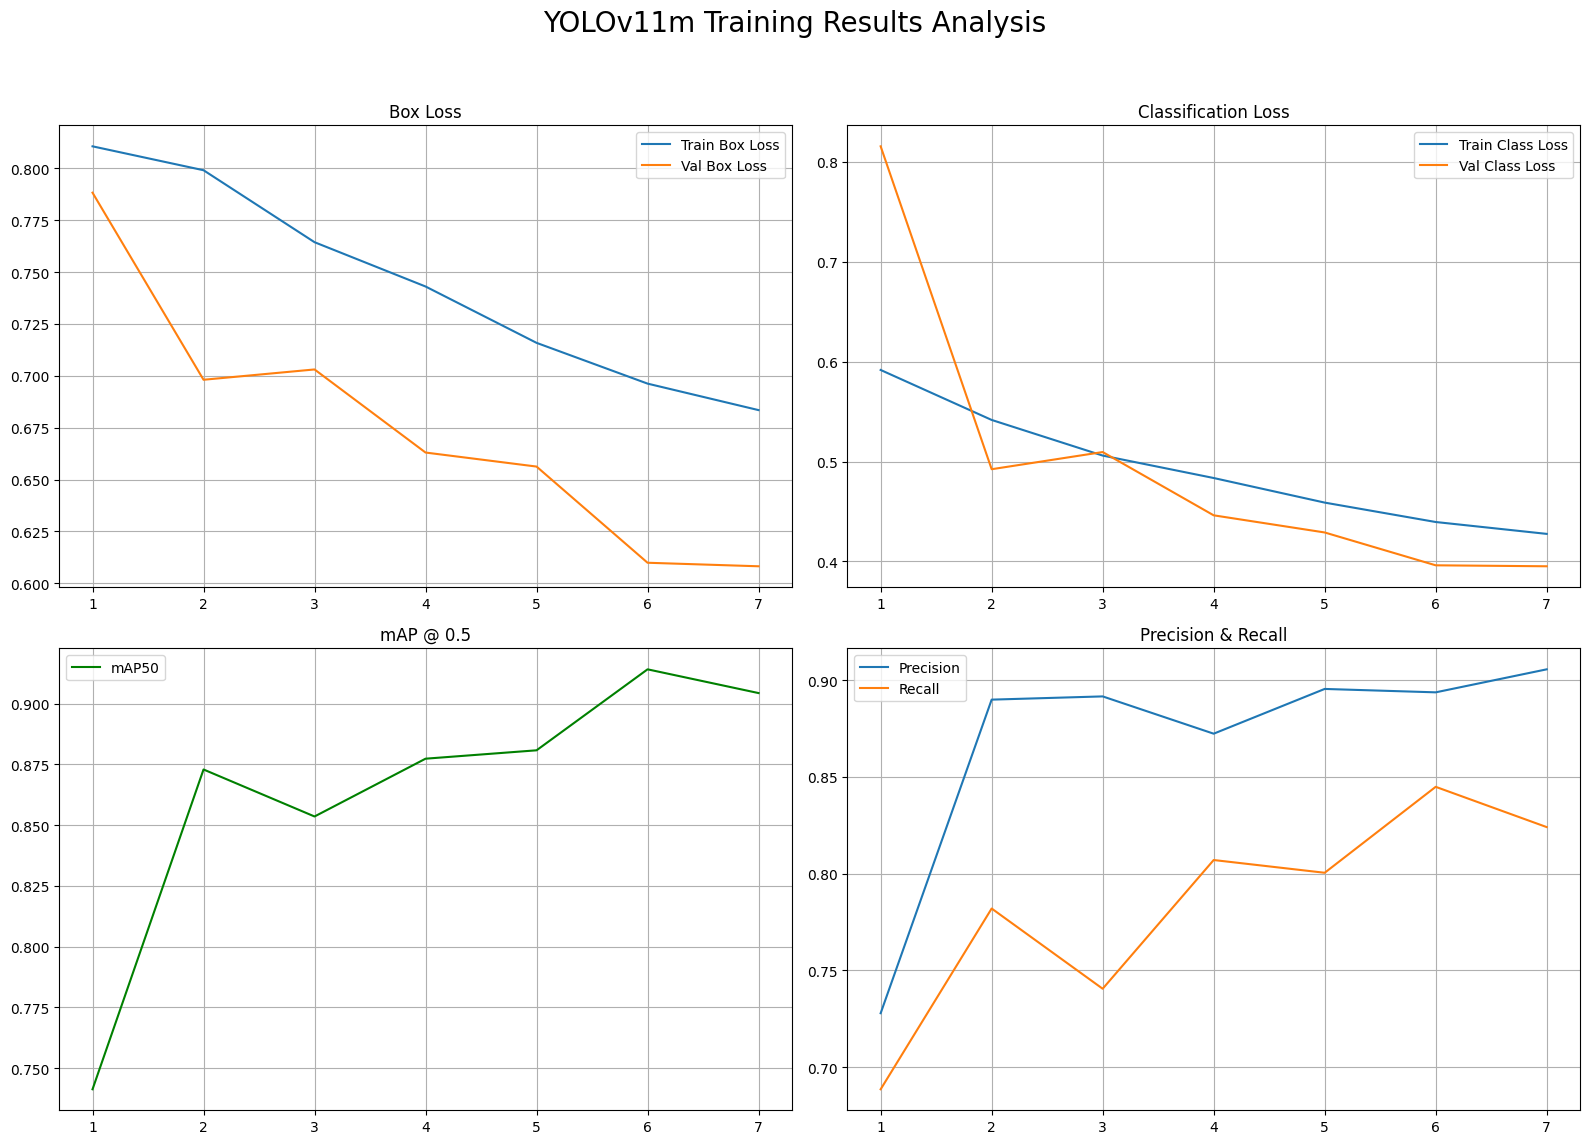

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# 학습 결과 폴더 경로
result_dir = '/content/SafeDrive_FCW/yolo11m_v11'
csv_path = os.path.join(result_dir, 'results.csv')

if os.path.exists(csv_path):
    # 1. CSV 데이터 로드
    df = pd.read_csv(csv_path)

    # 컬럼명에 공백이 포함된 경우가 많으므로 공백 제거
    df.columns = df.columns.str.strip()

    # 2. 그래프 그리기 (2행 2열 구조)
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))

    # (1) Loss 그래프 (Train vs Val)
    # Box Loss는 객체의 위치가 얼마나 정확한지를 나타냄
    axs[0, 0].plot(df['epoch'], df['train/box_loss'], label='Train Box Loss')
    axs[0, 0].plot(df['epoch'], df['val/box_loss'], label='Val Box Loss')
    axs[0, 0].set_title('Box Loss')
    axs[0, 0].legend()
    axs[0, 0].grid(True)

    # (2) Classification Loss 그래프
    # 객체가 Car인지 Bus인지 얼마나 잘 맞추는지를 나타냄
    axs[0, 1].plot(df['epoch'], df['train/cls_loss'], label='Train Class Loss')
    axs[0, 1].plot(df['epoch'], df['val/cls_loss'], label='Val Class Loss')
    axs[0, 1].set_title('Classification Loss')
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    # (3) mAP50 그래프
    # 신뢰도 임계값 0.5 기준의 평균 정밀도
    axs[1, 0].plot(df['epoch'], df['metrics/mAP50(B)'], color='green', label='mAP50')
    axs[1, 0].set_title('mAP @ 0.5')
    axs[1, 0].legend()
    axs[1, 0].grid(True)

    # (4) Precision & Recall 그래프
    axs[1, 1].plot(df['epoch'], df['metrics/precision(B)'], label='Precision')
    axs[1, 1].plot(df['epoch'], df['metrics/recall(B)'], label='Recall')
    axs[1, 1].set_title('Precision & Recall')
    axs[1, 1].legend()
    axs[1, 1].grid(True)

    plt.suptitle('YOLOv11m Training Results Analysis', fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

else:
    print(f"❌ '{csv_path}' 파일을 찾을 수 없습니다. 학습이 아직 시작되지 않았거나 경로를 확인해주세요.")

🧐 시각화 생성 및 객체 카운팅 분석 중...


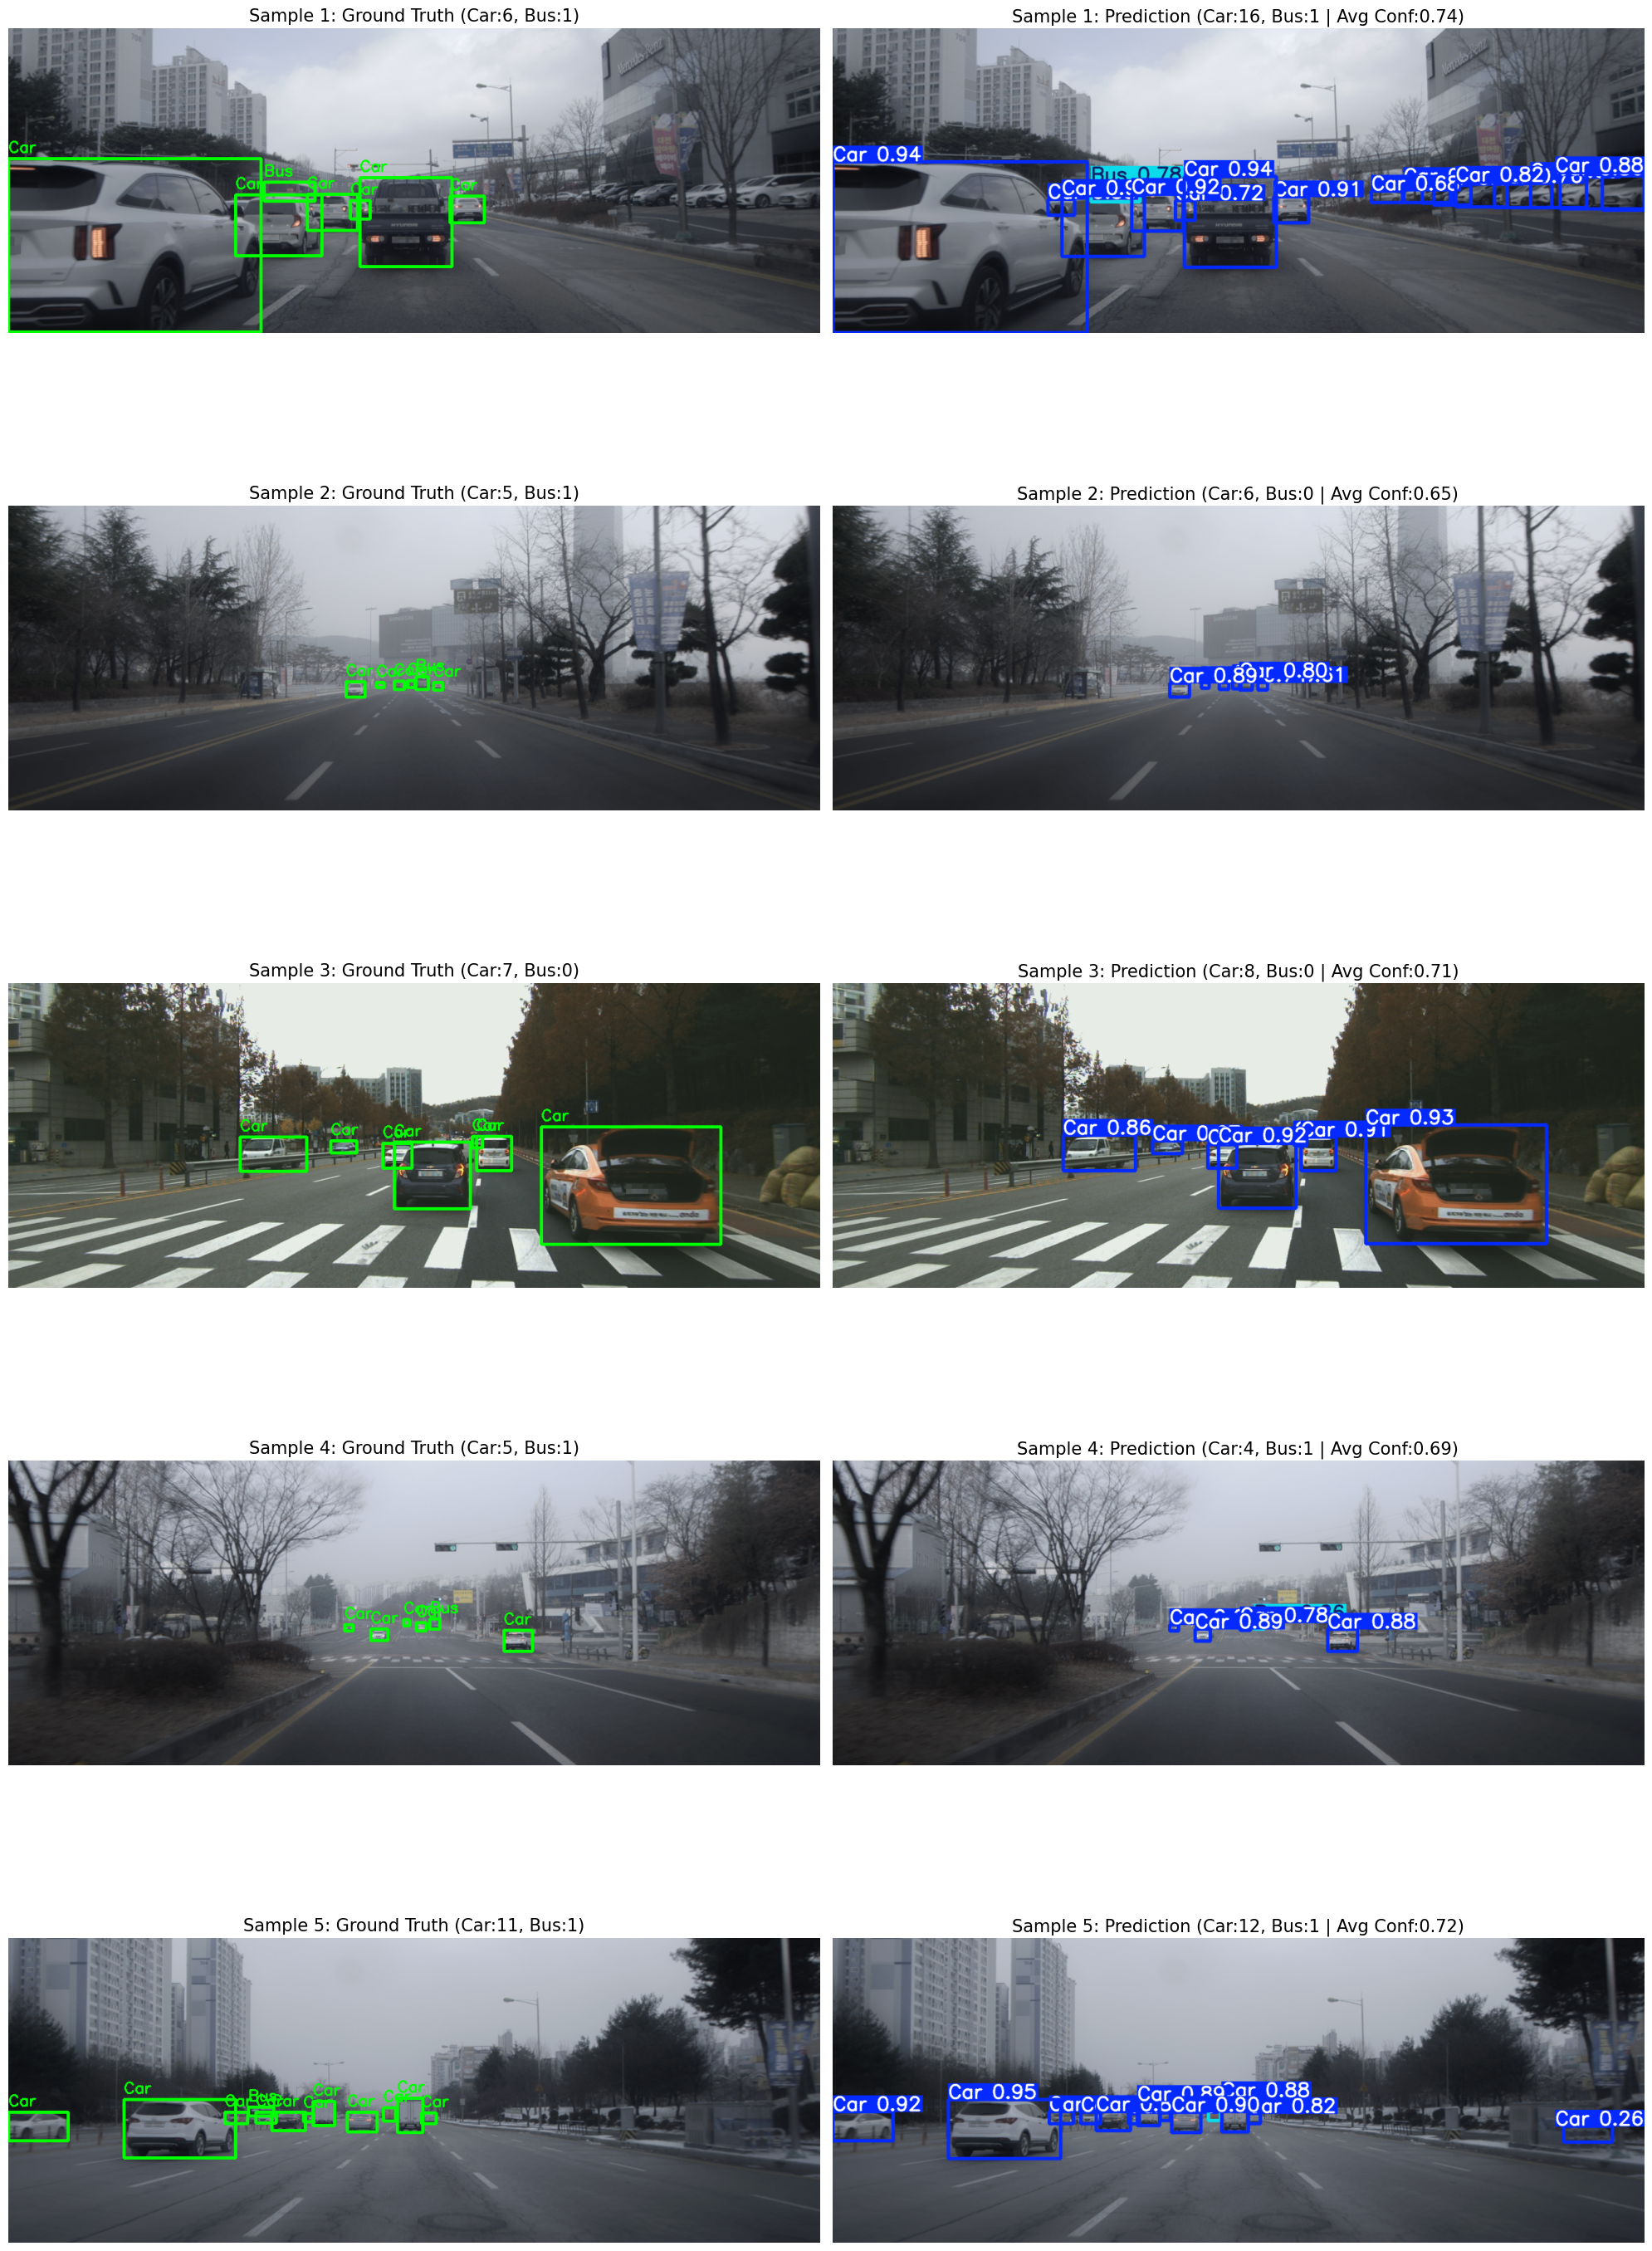


📊 [정답 vs 예측 객체 수 비교 분석표]


Sample ID                         File Name  GT Car  Pred Car  Diff Car  \
0  Sample 1  OisamtoBanseok_Snow_00024734.png       6        16        10   
1  Sample 2         ETRINear_Fog_00009283.png       5         6         1   
2  Sample 3                Yeonhwi_000702.png       7         8         1   
3  Sample 4         ETRINear_Fog_00004107.png       5         4        -1   
4  Sample 5  OisamtoBanseok_Snow_00029884.png      11        12         1   
5     TOTAL                                 -      34        46        12   

   GT Bus  Pred Bus  Diff Bus  
0       1         1         0  
1       1         0        -1  
2       0         0         0  
3       1         1         0  
4       1         1         0  
5       4         3        -1


🔍 분석 요약
⚠️ 전체 샘플에서 총 13개의 개수 오차가 발생했습니다. 시각화 자료를 통해 미검출/오검출 원인을 확인하세요.


In [24]:
import glob
import random
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO

# 1. 설정 및 경로
result_dir = '/content/SafeDrive_FCW/yolo11m_v11' # 결과 폴더 확인
model_path = os.path.join(result_dir, 'weights/best.pt')
model = YOLO(model_path)

test_img_dir = '/content/yolo_final_data/test/images'
test_label_dir = '/content/yolo_final_data/test/labels'
class_names = ['Car', 'Bus']

# 2. 테스트 이미지 무작위 선택 (5장)
test_images = glob.glob(os.path.join(test_img_dir, '*.png'))
num_samples = 5
sample_images = random.sample(test_images, num_samples)

# 3. 데이터 저장을 위한 리스트 및 시각화 준비
comparison_data = []
fig, axs = plt.subplots(num_samples, 2, figsize=(20, 6 * num_samples))

print("🧐 시각화 생성 및 객체 카운팅 분석 중...")

for i, img_path in enumerate(sample_images):
    file_name = os.path.basename(img_path)
    label_path = os.path.join(test_label_dir, file_name.replace('.png', '.txt'))

    # --- [A] Ground Truth 그리기 및 카운팅 ---
    img_gt = cv2.imread(img_path)
    img_gt = cv2.cvtColor(img_gt, cv2.COLOR_BGR2RGB)
    h, w, _ = img_gt.shape

    gt_car, gt_bus = 0, 0
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f.readlines():
                cls_id, xc, yc, nw, nh = map(float, line.split())
                cls_id = int(cls_id)

                # 카운팅
                if cls_id == 0: gt_car += 1
                elif cls_id == 1: gt_bus += 1

                # 정규화 좌표 -> 절대 좌표 변환 후 그리기
                x1 = int((xc - nw/2) * w)
                y1 = int((yc - nh/2) * h)
                x2 = int((xc + nw/2) * w)
                y2 = int((yc + nh/2) * h)

                cv2.rectangle(img_gt, (x1, y1), (x2, y2), (0, 255, 0), 3) # 녹색 박스
                cv2.putText(img_gt, f"{class_names[cls_id]}", (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

    # --- [B] Prediction 그리기 및 카운팅 ---
    results = model.predict(source=img_path, conf=0.25, verbose=False)
    img_pred = results[0].plot() # 모델 기본 플로팅
    img_pred = cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB)

    # 예측 결과 카운팅
    pred_cls_list = results[0].boxes.cls.cpu().numpy().astype(int)
    pred_car = (pred_cls_list == 0).sum()
    pred_bus = (pred_cls_list == 1).sum()

    # --- [C] 플롯 배치 ---
    # 왼쪽: Ground Truth
    axs[i, 0].imshow(img_gt)
    axs[i, 0].set_title(f"Sample {i+1}: Ground Truth (Car:{gt_car}, Bus:{gt_bus})", fontsize=15)
    axs[i, 0].axis('off')

    # 오른쪽: Prediction
    axs[i, 1].imshow(img_pred)
    conf_avg = results[0].boxes.conf.mean().item() if len(results[0].boxes.conf) > 0 else 0
    axs[i, 1].set_title(f"Sample {i+1}: Prediction (Car:{pred_car}, Bus:{pred_bus} | Avg Conf:{conf_avg:.2f})", fontsize=15)
    axs[i, 1].axis('off')

    # --- [D] 통계 데이터 저장 ---
    comparison_data.append({
        'Sample ID': f"Sample {i+1}",
        'File Name': file_name,
        'GT Car': gt_car,
        'Pred Car': pred_car,
        'Diff Car': pred_car - gt_car,
        'GT Bus': gt_bus,
        'Pred Bus': pred_bus,
        'Diff Bus': pred_bus - gt_bus
    })

plt.tight_layout()
plt.show()

# 4. 비교 결과 표(DataFrame) 생성 및 출력
df = pd.DataFrame(comparison_data)

# TOTAL 행 추가
total_row = df.sum(numeric_only=True).to_dict()
total_row['Sample ID'] = 'TOTAL'
total_row['File Name'] = '-'
df = pd.concat([df, pd.DataFrame([total_row])], ignore_index=True)

print("\n📊 [정답 vs 예측 객체 수 비교 분석표]")
display(df) # 코랩 환경용 출력

# 5. 요약 인사이트 출력
print("\n🔍 분석 요약")
total_diff = abs(df.iloc[-1]['Diff Car']) + abs(df.iloc[-1]['Diff Bus'])
if total_diff == 0:
    print("✅ 모든 샘플에서 객체 개수를 정확하게 맞췄습니다!")
else:
    print(f"⚠️ 전체 샘플에서 총 {int(total_diff)}개의 개수 오차가 발생했습니다. 시각화 자료를 통해 미검출/오검출 원인을 확인하세요.")

In [18]:
results[0]

ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'Car', 1: 'Bus'}
obb: None
orig_img: array([[[28, 25, 19],
        [30, 27, 21],
        [36, 30, 20],
        ...,
        [42, 51, 40],
        [41, 48, 42],
        [37, 44, 38]],

       [[30, 28, 19],
        [32, 30, 21],
        [43, 35, 25],
        ...,
        [42, 53, 42],
        [45, 53, 45],
        [43, 51, 43]],

       [[38, 29, 21],
        [41, 32, 24],
        [50, 39, 30],
        ...,
        [42, 54, 47],
        [48, 57, 51],
        [48, 57, 51]],

       ...,

       [[40, 47, 41],
        [42, 49, 43],
        [42, 49, 43],
        ...,
        [47, 56, 45],
        [48, 56, 48],
        [51, 59, 51]],

       [[40, 47, 41],
        [39, 46, 40],
        [42, 49, 43],
        ...,
        [48, 59, 48],
        [50, 60, 52],
        [47, 57, 49]],

       [[40, 48, 40],
        [37, 45, 37],
        [39, 46, 40],
   

### YOLO11n 모델 학습 후 속도 비교

In [8]:
from ultralytics import YOLO
import os

# 1. 모델 로드 (YOLOv11n)
model = YOLO('yolo11n.pt')

# 2. 데이터셋 경로
DATA_YAML_PATH = '/content/yolo_final_data/data.yaml'

# 3. T4 GPU 맞춤형 고성능 학습 설정
results = model.train(
    data=DATA_YAML_PATH,
    epochs=50,            # Nano 모델은 충분한 에폭이 필요합니다.
    patience=50,           # 조기 종료 방지
    batch=64,              # T4(16GB)에서 imgsz=640일 때 64가 가장 안정적이고 빠릅니다.
    imgsz=640,
    workers=4,             # T4 세션의 CPU 코어 수를 고려하여 4~8 권장

    # --- [성능 극대화 하이퍼파라미터] ---
    optimizer='AdamW',     # 복잡한 도로 상황에서 수렴 성능이 좋음
    lr0=0.01,              # 초기 학습률 (표준값 유지)
    lrf=0.01,              # 최종 학습률
    cos_lr=True,           # 코사인 스케줄러 (후반부 미세 조정 필수)
    label_smoothing=0.1,   # 과적합 방지 및 일반화 성능 향상

    # --- [성능 극대화 데이터 증강] ---
    mosaic=1.0,            # 필수: 작은 객체 검출력 향상
    mixup=0.1,             # 이미지 혼합
    copy_paste=0.1,        # 차량 객체 복사/붙여넣기 (객체 인식 밀도 향상)
    hsv_v=0.4,             # 명도 변화 (다양한 날씨/조명 대응)
    fliplr=0.5,            # 좌우 반전
    close_mosaic=15,       # 매우 중요: 마지막 15에폭은 Mosaic을 끄고 박스 정밀도 튜닝

    # --- 시스템 설정 ---
    device=0,
    project='SafeDrive_T4_HighPerf',
    name='yolo11n_mAP90_exp',
    amp=True,              # T4의 Mixed Precision 연산 활성화 (속도/메모리 최적화)
    pretrained=True,
    exist_ok=True,
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
WARNING ⚠️ 'label_smoothing' is deprecated and will be removed in the future.
Ultralytics 8.3.252 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=64, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=15, cls=0.5, compile=False, conf=None, copy_paste=0.1, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/yolo_final_data/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=Fa

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [12]:
import time
import torch

def benchmark_model(model_path, img_path, device='cuda'):
    model = YOLO(model_path)
    # GPU 예열 (Warm-up)
    for _ in range(10):
        model.predict(img_path, device=device, verbose=False)

    # 실제 속도 측정
    start_time = time.time()
    num_iters = 100
    for _ in range(num_iters):
        model.predict(img_path, device=device, verbose=False)
    end_time = time.time()

    avg_time = (end_time - start_time) / num_iters * 1000 # ms
    fps = 1000 / avg_time
    return avg_time, fps

# 테스트용 이미지 하나 선택
test_img = '/content/yolo_final_data/test/images/CounterClock2_Fog_00003103.png' # 실제 경로로 수정

# 1. Medium 모델 속도 측정 (이전 결과)
m_time, m_fps = benchmark_model('/content/yolo11m/best.pt', test_img)
# 2. Nano 모델 속도 측정 (방금 결과)
n_time, n_fps = benchmark_model('/content/SafeDrive_T4_HighPerf/yolo11n_mAP90_exp/weights/best.pt', test_img)

print(f"\n[모델 속도 비교 리포트]")
print(f"🔹 YOLOv11m: {m_time:.2f} ms | {m_fps:.1f} FPS")
print(f"🔹 YOLOv11n: {n_time:.2f} ms | {n_fps:.1f} FPS")
print(f"🚀 속도 향상 폭: {n_fps/m_fps:.2f}배 빨라짐")


[모델 속도 비교 리포트]
🔹 YOLOv11m: 24.03 ms | 41.6 FPS
🔹 YOLOv11n: 23.21 ms | 43.1 FPS
🚀 속도 향상 폭: 1.04배 빨라짐


In [1]:
!pip install ultralytics opencv-python matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 21.0 MB/s eta 0:00:00


In [3]:
import cv2
import os
import glob
import imageio
from ultralytics import YOLO
from tqdm import tqdm

def create_inference_video(model_path, input_folder, output_name="inference_result.mp4", conf=0.25):
    # 1. 모델 로드
    model = YOLO(model_path)

    # 2. 이미지 파일 가져오기 및 정렬
    # png, jpg, jpeg 모두 지원하도록 검색
    img_files = sorted(glob.glob(os.path.join(input_folder, "*.[pj][n+e]g")))

    if not img_files:
        print("❌ 폴더 내에 이미지가 없습니다. 경로를 확인해주세요.")
        return

    # 첫 번째 이미지를 읽어 해상도 확인
    first_frame = cv2.imread(img_files[0])
    h, w, _ = first_frame.shape

    # 3. 영상 저장을 위한 Writer 설정 (H.264 코덱 사용)
    writer = imageio.get_writer(output_name, fps=20, codec='libx264', quality=8)

    print(f"🎬 영상 생성 시작: {output_name} ({w}x{h})")

    # 4. 추론 및 프레임 저장
    for img_p in tqdm(img_files):
        # 모델 예측
        results = model.predict(source=img_p, conf=conf, device='cuda', verbose=False)

        # 바운딩 박스가 그려진 이미지 가져오기
        # .plot()은 BGR 배열을 반환함
        res_frame = results[0].plot()

        # BGR(OpenCV) -> RGB(imageio/Video) 변환
        res_rgb = cv2.cvtColor(res_frame, cv2.COLOR_BGR2RGB)

        # 영상에 추가
        writer.append_data(res_rgb)

    writer.close()
    print(f"✅ 영상 저장 완료: {os.getcwd()}/{output_name}")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
MODEL_PATH = '/content/best.pt'
NEW_DATA_FOLDER = '/content/drive/MyDrive/Capture'
create_inference_video(MODEL_PATH, NEW_DATA_FOLDER, "New_Dataset_Result.mp4")

🎬 영상 생성 시작: New_Dataset_Result.mp4 (1920x926)


100%|██████████| 29/29 [00:26<00:00,  1.11it/s]


✅ 영상 저장 완료: /content/New_Dataset_Result.mp4


In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.6 MB/s eta 0:00:00


In [2]:
import os
import glob
from ultralytics import YOLO
from tqdm import tqdm

def save_absolute_predictions(model_path, input_folder, output_folder, conf=0.25):
    # 1. 모델 로드
    model = YOLO(model_path)

    # 2. 출력 폴더 생성
    os.makedirs(output_folder, exist_ok=True)

    # 3. 이미지 파일 목록 가져오기
    img_files = glob.glob(os.path.join(input_folder, "*.[pj][n+e]g"))

    print(f"🚀 절대 좌표 라벨 저장 시작 (총 {len(img_files)}장)")

    for img_p in tqdm(img_files):
        # 파일명 추출 (확장자 제외)
        file_name = os.path.splitext(os.path.basename(img_p))[0]
        txt_path = os.path.join(output_folder, f"{file_name}.txt")

        # 모델 추론
        results = model.predict(source=img_p, conf=conf, device='cuda', verbose=False)

        with open(txt_path, 'w') as f:
            for result in results:
                boxes = result.boxes
                for box in boxes:
                    # 1. 절대 좌표 추출 [x1, y1, x2, y2] (픽셀 단위)
                    xyxy = box.xyxy[0].cpu().numpy()
                    x1, y1, x2, y2 = map(int, xyxy) # 정수(픽셀)로 변환

                    # 2. 클래스 ID (0: Car, 1: Bus 등)
                    cls = int(box.cls[0])

                    # 3. 파일 저장 포맷: x1 y1 x2 y2 agent_id
                    # (기존 프로젝트 포맷의 0~4번 인덱스에 해당)
                    line = f"{x1} {y1} {x2} {y2} {cls}\n"
                    f.write(line)

# --- 실행 부분 ---
MODEL_PATH = '/content/best.pt'              # 학습된 모델 경로
INPUT_DIR = '/content/drive/MyDrive/Capture'          # 추론할 이미지 폴더
OUTPUT_DIR = './labels'    # 결과 txt가 저장될 폴더

save_absolute_predictions(MODEL_PATH, INPUT_DIR, OUTPUT_DIR)
print(f"✅ 저장 완료! '{OUTPUT_DIR}' 폴더를 확인하세요.")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
🚀 절대 좌표 라벨 저장 시작 (총 29장)


100%|██████████| 29/29 [00:34<00:00,  1.18s/it]

✅ 저장 완료! './labels' 폴더를 확인하세요.


In [3]:
!zip /content/labels -r /content/labels

  adding: content/labels/ (stored 0%)
  adding: content/labels/bb_1_140613_vehicle_224_55460.mp4_20260114_143208.935.txt (deflated 43%)
  adding: content/labels/bb_1_140613_vehicle_224_55460.mp4_20260114_143211.603.txt (deflated 43%)
  adding: content/labels/bb_1_140613_vehicle_224_55460.mp4_20260114_143213.602.txt (deflated 46%)
  adding: content/labels/bb_1_140613_vehicle_224_55460.mp4_20260114_143206.936.txt (deflated 45%)
  adding: content/labels/bb_1_140613_vehicle_224_55460.mp4_20260114_143206.269.txt (deflated 48%)
  adding: content/labels/bb_1_140613_vehicle_224_55460.mp4_20260114_143207.269.txt (deflated 44%)
  adding: content/labels/bb_1_140613_vehicle_224_55460.mp4_20260114_143204.938.txt (deflated 49%)
  adding: content/labels/bb_1_140613_vehicle_224_55460.mp4_20260114_143212.934.txt (deflated 49%)
  adding: content/labels/bb_1_140613_vehicle_224_55460.mp4_20260114_143204.270.txt (deflated 49%)
  adding: content/labels/bb_1_140613_vehicle_224_55460.mp4_20260114_143207.603.t

In [7]:
import os
import glob
import cv2
import numpy as np
from ultralytics import YOLO
from tqdm import tqdm

def save_tracked_labels_fixed_lines(model_path, input_folder, output_folder):
    # 1. 모델 로드
    model = YOLO(model_path)
    os.makedirs(output_folder, exist_ok=True)

    # 2. 이미지 파일 정렬 (시계열 추적을 위해 정렬 필수)
    img_files = sorted(glob.glob(os.path.join(input_folder, "*.[pj][n+e]g")))

    # [핵심] 시퀀스 전체에서 발견된 모든 track_id를 추적하기 위한 리스트
    all_seen_ids = []
    # 각 프레임의 결과를 임시 저장할 딕셔너리 {frame_name: {track_id: [x1, y1, x2, y2, cls]}}
    frame_results = {}

    print(f"🚀 객체 추적 시작 (ByteTrack 사용)...")

    # --- [Step 1] 전체 프레임 추적 및 데이터 수집 ---
    for img_p in tqdm(img_files):
        file_name = os.path.basename(img_p)

        # persist=True: 프레임 간 ID를 유지함
        # tracker='bytetrack.yaml' 사용
        results = model.track(source=img_p, persist=True, conf=0.25, tracker="bytetrack.yaml", verbose=False)

        frame_data = {}
        if results[0].boxes.id is not None:
            # 추적된 정보 추출
            boxes = results[0].boxes.xyxy.cpu().numpy()
            ids = results[0].boxes.id.cpu().numpy().astype(int)
            clss = results[0].boxes.cls.cpu().numpy().astype(int)

            for box, tid, cls in zip(boxes, ids, clss):
                frame_data[tid] = list(map(int, box)) + [cls]
                if tid not in all_seen_ids:
                    all_seen_ids.append(tid)

        frame_results[file_name] = frame_data

    # ID 순서대로 정렬 (파일 내 줄 번호를 고정하기 위함)
    all_seen_ids.sort()

    print(f"📝 라벨 파일 저장 중 (총 고유 객체 수: {len(all_seen_ids)})...")

    # --- [Step 2] 고정 라인 형식으로 파일 저장 ---
    for img_p in img_files:
        file_name = os.path.basename(img_p)
        txt_name = os.path.splitext(file_name)[0] + ".txt"
        txt_path = os.path.join(output_folder, txt_name)

        current_frame_data = frame_results[file_name]

        with open(txt_path, 'w') as f:
            # 발견된 모든 ID에 대해 루프를 돌며 줄을 맞춤
            for tid in all_seen_ids:
                if tid in current_frame_data:
                    # 객체가 존재하는 경우: x1 y1 x2 y2 agent_id
                    d = current_frame_data[tid]
                    line = f"{d[0]} {d[1]} {d[2]} {d[3]} {d[4]}\n"
                else:
                    # 객체가 사라졌거나 아직 나타나지 않은 경우: 0 0 0 0 -1 (또는 0)
                    line = "0 0 0 0 0\n"

                f.write(line)

# --- 실행 ---
MODEL_PATH = '/content/best.pt'              # 학습된 모델 경로
INPUT_DIR = '/content/drive/MyDrive/Capture'          # 추론할 이미지 폴더
OUTPUT_DIR = './tracked_fixed_labels'

save_tracked_labels_fixed_lines(MODEL_PATH, INPUT_DIR, OUTPUT_DIR)
print(f"✅ 저장 완료!")

🚀 객체 추적 시작 (ByteTrack 사용)...


100%|██████████| 29/29 [00:01<00:00, 28.43it/s]

📝 라벨 파일 저장 중 (총 고유 객체 수: 42)...
✅ 저장 완료!
